In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('yield.csv', header=0, sep=';', index_col=0, squeeze=True, parse_dates=True)

In [4]:
df = df.to_frame().reset_index()

In [5]:
df = df.rename({"date":"ds","yield":"y"}, axis='columns') 

In [6]:
df['ds'] = pd.to_datetime(df['ds']) #convert date to datetime object

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51894 entries, 0 to 51893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      51894 non-null  datetime64[ns]
 1   y       51894 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 811.0 KB
None


In [12]:
#create the model
m = Prophet(daily_seasonality=True).fit(df)
#placeholder to hold our future predictions
future = m.make_future_dataframe(periods=365, freq='D' )
# fcst = m.predict(future)
# fig = m.plot(fcst)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [14]:
future.head()

,ds
0,2019-09-12
1,2019-10-12
2,2019-11-12
3,2019-12-12
4,2019-12-13


In [15]:
future.tail()

,ds
726,2021-12-07
727,2021-12-08
728,2021-12-09
729,2021-12-10
730,2021-12-11


Reference: https://nextjournal.com/eric-brown/forecasting-with-prophet-part-4

In [16]:
#predict and fill in the future
forecast= m.predict(future)

In [18]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-12,3621.290224,-1712.516937,3290.184213,3621.290224,3621.290224,-2792.348521,-2792.348521,-2792.348521,-2708.423815,-2708.423815,-2708.423815,-83.924705,-83.924705,-83.924705,0.0,0.0,0.0,828.941703
1,2019-10-12,3782.812157,-1432.606570,3580.095468,3782.812157,3782.812157,-2695.818317,-2695.818317,-2695.818317,-2708.423815,-2708.423815,-2708.423815,12.605499,12.605499,12.605499,0.0,0.0,0.0,1086.993840
2,2019-11-12,3949.718154,-1140.253373,3681.933961,3949.718154,3949.718154,-2673.306129,-2673.306129,-2673.306129,-2708.423815,-2708.423815,-2708.423815,35.117687,35.117687,35.117687,0.0,0.0,0.0,1276.412026
3,2019-12-12,4111.240087,-1053.800163,3786.906674,4111.240087,4111.240087,-2792.348521,-2792.348521,-2792.348521,-2708.423815,-2708.423815,-2708.423815,-83.924705,-83.924705,-83.924705,0.0,0.0,0.0,1318.891567
4,2019-12-13,4116.624152,-1162.344221,3837.036891,4116.624152,4116.624152,-2813.502934,-2813.502934,-2813.502934,-2708.423815,-2708.423815,-2708.423815,-105.079118,-105.079118,-105.079118,0.0,0.0,0.0,1303.121218


In [19]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [21]:
forecast[['ds','yhat_lower', 'yhat_upper', 'yhat' ]].tail(20)

,ds,yhat_lower,yhat_upper,yhat
711,2021-11-22,-3839.661407,6663.495181,1701.505267
712,2021-11-23,-3743.014871,6959.483746,1610.719281
713,2021-11-24,-4076.325907,6682.196277,1626.366686
714,2021-11-25,-4071.599459,6607.122623,1490.642155
715,2021-11-26,-4082.645534,6959.041676,1468.970374
716,2021-11-27,-4038.678499,7064.419354,1586.137624
717,2021-11-28,-3791.693392,6747.002390,1537.626633
718,2021-11-29,-3660.273825,7114.637192,1697.883696
719,2021-11-30,-4126.976386,6721.223179,1607.097710
720,2021-12-01,-3956.351359,6590.720476,1622.745115


(737272.95, 738176.05)

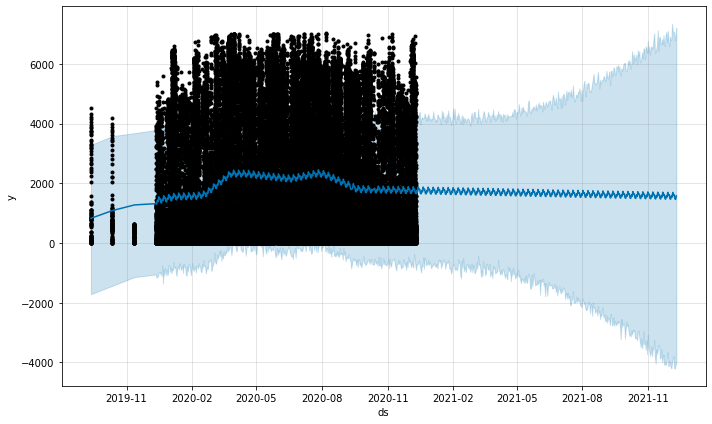

In [31]:
import matplotlib.pyplot as plt
m.plot(forecast);
plt.xlim()

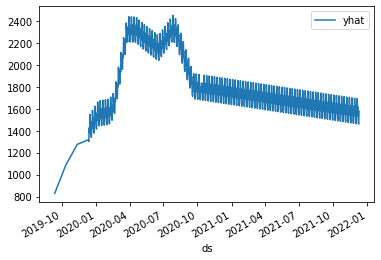

In [33]:
forecast.plot(x='ds', y= 'yhat')

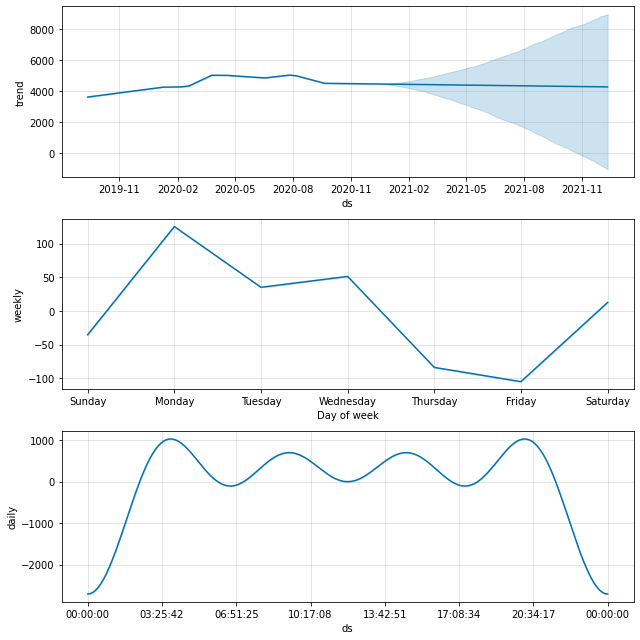

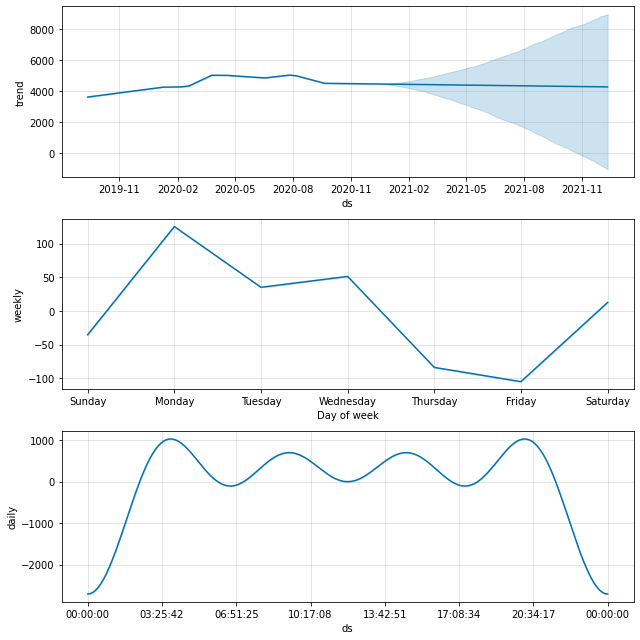

In [34]:
m.plot_components(forecast)

Reference : Diagnostics https://facebook.github.io/prophet/docs/diagnostics.html

In [51]:
#Here we do cross-validation to assess prediction performance on a horizon of 100 days, starting with 200 days of training data in the first cutoff and then making predictions every 18 days.
#On this 2 year time series, this corresponds to 9 total forecasts.
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='200 days', period='18 days', horizon = '100 days')


INFO:fbprophet:Making 9 forecasts with cutoffs between 2020-04-11 00:00:00 and 2020-09-02 00:00:00


In [52]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,10 days,4.288246e+06,2070.808124,1793.847185,0.671346,0.774185
1,11 days,4.286900e+06,2070.483102,1789.491338,0.658200,0.770224
2,12 days,4.267824e+06,2065.871221,1783.898997,0.660751,0.770486
3,13 days,4.270324e+06,2066.476320,1784.741792,0.669688,0.769158
4,14 days,4.217132e+06,2053.565569,1769.776835,0.666549,0.775102


In [53]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()

In [54]:
metric_df.tail()

,ds,yhat,y
52254,2021-12-07,1603.476139,NaN
52255,2021-12-08,1619.123543,NaN
52256,2021-12-09,1483.399012,NaN
52257,2021-12-10,1461.727232,NaN
52258,2021-12-11,1578.894482,NaN


You can see from the above, that the last part of the dataframe has NaN for y... that's fine because we are only concerned about checking the forecast values versus the actual values so we can drop these NaN values.

In [55]:
metric_df.dropna(inplace=True)

In [56]:
metric_df.tail()

,ds,yhat,y
51889,2020-12-11,1650.048931,47.0
51890,2020-12-11,1650.048931,22.0
51891,2020-12-11,1650.048931,0.0
51892,2020-12-11,1650.048931,0.0
51893,2020-12-11,1650.048931,0.0


In [58]:
#calculation of Root squared score
from sklearn.metrics import r2_score
r2_score(metric_df.y, metric_df.yhat)

0.02808053018984813

In [65]:
#calculating root mean square error . For MSE, closer to zero is better
from sklearn.metrics import mean_squared_error
from math import sqrt
mse= mean_squared_error(metric_df.y, metric_df.yhat)
rmse = sqrt(mse)
print("The root mean square error is:", rmse)

The root mean square error is: 1908.4682675910374
